# **Capstone Project**
## Parth Jariwala - 21BAI1276 & Chitraksh Kumar - 21BCE5319

### 1) Data Pre-Processing

EEG montage:
--
	Channel 1: Fz
	Channel 2: Pz
	Channel 3: P3
	Channel 4: P4
	Channel 5: Cz
	Channel 6: EXT
	Channel 7: CP5
	Channel 8: CP6

In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikit-learn

In [ ]:
!pip install antropy

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.signal import resample, butter, filtfilt, iirnotch, welch
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from antropy import spectral_entropy

In [ ]:
data_path = "/content/drive/MyDrive"
categories = ["Cybersick", "Normal"]

In [ ]:
def get_eeg_duration(file_path):
    try:
        data = np.loadtxt(file_path, delimiter='\t')  # Change delimiter if needed

        if data.shape[1] < 13:
            raise ValueError("File does not have enough columns. Expected at least 13.")

        timestamps = data[:, -1]

        duration = (timestamps[-1] - timestamps[0]) / 1000  # Convert from ms to seconds

        hours = int(duration // 3600)
        minutes = int((duration % 3600) // 60)

        print(f"Duration: {hours} hours {minutes} min")

    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

In [ ]:
for i in range(1, 21):
  file_path = f"/content/drive/MyDrive/Normal/ndata{i}.easy"
  duration = get_eeg_duration(file_path)

Duration: 1 hours 36 min
Duration: 1 hours 31 min
Duration: 1 hours 21 min
Duration: 1 hours 24 min
Duration: 1 hours 25 min
Error reading /content/drive/MyDrive/Normal/ndata6.easy: /content/drive/MyDrive/Normal/ndata6.easy not found.
Duration: 1 hours 28 min
Duration: 0 hours 45 min
Duration: 1 hours 24 min
Duration: 1 hours 21 min
Duration: 1 hours 28 min
Duration: 1 hours 26 min
Duration: 1 hours 22 min
Duration: 1 hours 21 min
Duration: 1 hours 37 min
Duration: 1 hours 27 min
Duration: 1 hours 20 min


In [ ]:
for i in range(1, 21):
  file_path = f"/content/drive/MyDrive/Cybersick/data{i}.easy"
  duration = get_eeg_duration(file_path)

### **Filtering data**

# Bandpass filter to isolate relevant EEG frequences

In [ ]:
def bandpass_filter(data, lowcut=4.0, highcut=40.0, fs=500, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

Notch filter to remove powerline interface

In [ ]:
def notch_filter(data, notch_freq=50.0, fs=500 , quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data, axis=0)

Apply Independent Component Analysis

In [ ]:
from sklearn.decomposition import FastICA
def apply_ica(data, n_components=8):
    ica = FastICA(n_components=n_components, random_state=42)
    return ica.fit_transform(data)

In [ ]:

def ensure_dataframe(data):

    if isinstance(data, np.ndarray):
        return pd.DataFrame(data)
    return data


In [ ]:
from scipy.fftpack import fft

def compute_fft(eeg_data, sampling_rate=500):
    n = eeg_data.shape[0]  # Number of samples
    freqs = np.fft.fftfreq(n, 1/sampling_rate)[:n//2]  # Positive frequencies only
    fft_magnitudes = np.abs(fft(eeg_data, axis=0))[:n//2]  # Magnitude of FFT

    mask = freqs <= 60

    return freqs[mask], fft_magnitudes[mask]

    return fft_results

In [ ]:
def segment_eeg(eeg_data, timestamps, segment_duration=60, fs=500):
    """ Split EEG data into fixed 60-second segments. """
    samples_per_segment = segment_duration * fs
    total_samples = eeg_data.shape[0]
    segments = []

    for start in range(0, total_samples, samples_per_segment):
        end = start + samples_per_segment
        if end <= total_samples:  # Only keep complete segments
            segments.append(eeg_data[start:end, :])

    return segments

In [ ]:
def compute_features(eeg_segment, fs=256):
    """ Compute statistical and frequency domain features for a given EEG segment. """
    features = {}

    for ch in range(eeg_segment.shape[1]):  # Loop over EEG channels
        data = eeg_segment[:, ch]

        # Statistical Features
        features[f'Ch{ch+1}_Mean'] = np.mean(data)
        features[f'Ch{ch+1}_Std'] = np.std(data)
        features[f'Ch{ch+1}_Variance'] = np.var(data)
        features[f'Ch{ch+1}_Skewness'] = skew(data)
        features[f'Ch{ch+1}_Kurtosis'] = kurtosis(data)
        features[f'Ch{ch+1}_RMS'] = np.sqrt(np.mean(data**2))
        features[f'Ch{ch+1}_Peak-to-Peak'] = np.ptp(data)
        features[f'Ch{ch+1}_Entropy'] = spectral_entropy(data, sf=fs, method='welch')

        # Frequency Domain Features
        freqs, psd = welch(data, fs=fs, nperseg=fs*2)
        bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13),
                 'Beta': (13, 30), 'Gamma': (30, 100)}

        total_power = np.sum(psd)
        for band, (low, high) in bands.items():
            band_power = np.sum(psd[(freqs >= low) & (freqs < high)])
            features[f'Ch{ch+1}_{band}_Power'] = band_power
            features[f'Ch{ch+1}_{band}_Relative_Power'] = band_power / total_power

        # Peak frequency
        features[f'Ch{ch+1}_Peak_Frequency'] = freqs[np.argmax(psd)]

    return features


In [ ]:
def statistical_feature_extraction(data_dir, output_csv, max_files=40, fs=500):
    """ Load EEG files, segment, extract features, and save to CSV. """
    all_features = []
    files = sorted(os.listdir(data_dir))[:max_files]  # Limit to first `max_files` files

    if ".ipynb_checkpoints" in files:
        files.remove(".ipynb_checkpoints")

    for file in files:
        file_path = os.path.join(data_dir, file)
        print(f"Processing {file}... {file_path}")


        eeg_data, timestamps = process_eeg_file(file_path)
        if eeg_data is None:
            continue

        segments = segment_eeg(eeg_data, timestamps, segment_duration=60, fs=fs)

        for i, segment in enumerate(segments):
            features = compute_features(segment, fs=fs)
            features["File"] = file
            features["Segment"] = i + 1
            all_features.append(features)

    # Convert to DataFrame and save
    df_features = pd.DataFrame(all_features)
    df_features.to_csv(output_csv, index=False)
    print(f"Feature extraction complete. Saved to {output_csv}")

Apply to our data

In [ ]:
def process_eeg_file(file_path):
    try:
        # Load data with all columns (including timestamp)
        df = pd.read_csv(file_path, delimiter='\t', header=None)

        # Separate EEG data (first 8 columns) and timestamp (last column)
        eeg_data = df.iloc[:, :8]
        timestamp_data = df.iloc[:, -1]

        # Apply bandpass filter
        eeg_data = bandpass_filter(eeg_data.values)

        # Apply notch filter
        eeg_data = notch_filter(eeg_data)

        # Apply ICA for artifact removal
        eeg_data = apply_ica(eeg_data)

        return eeg_data, timestamp_data

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

In [ ]:
statistical_feature_extraction(data_dir="/content/drive/MyDrive/Cybersick/", output_csv="cybersick_features.csv", max_files=20)


Processing data1.easy... /content/drive/MyDrive/Cybersick/data1.easy
Processing data10.easy... /content/drive/MyDrive/Cybersick/data10.easy
Processing data11.easy... /content/drive/MyDrive/Cybersick/data11.easy
Processing data12.easy... /content/drive/MyDrive/Cybersick/data12.easy
Processing data13.easy... /content/drive/MyDrive/Cybersick/data13.easy
Processing data14.easy... /content/drive/MyDrive/Cybersick/data14.easy
Processing data15.easy... /content/drive/MyDrive/Cybersick/data15.easy
Processing data16.easy... /content/drive/MyDrive/Cybersick/data16.easy
Processing data17.easy... /content/drive/MyDrive/Cybersick/data17.easy
Processing data18.easy... /content/drive/MyDrive/Cybersick/data18.easy
Processing data19.easy... /content/drive/MyDrive/Cybersick/data19.easy
Processing data2.easy... /content/drive/MyDrive/Cybersick/data2.easy
Processing data20.easy... /content/drive/MyDrive/Cybersick/data20.easy
Processing data3.easy... /content/drive/MyDrive/Cybersick/data3.easy
Processing d

In [ ]:
statistical_feature_extraction(data_dir="/content/drive/MyDrive/Normal/", output_csv="normal_features.csv", max_files=20)

Processing ndata1.easy... /content/drive/MyDrive/Normal/ndata1.easy
Processing ndata10.easy... /content/drive/MyDrive/Normal/ndata10.easy
Processing ndata11.easy... /content/drive/MyDrive/Normal/ndata11.easy
Processing ndata12.easy... /content/drive/MyDrive/Normal/ndata12.easy
Processing ndata13.easy... /content/drive/MyDrive/Normal/ndata13.easy
Processing ndata14.easy... /content/drive/MyDrive/Normal/ndata14.easy
Processing ndata15.easy... /content/drive/MyDrive/Normal/ndata15.easy
Processing ndata16.easy... /content/drive/MyDrive/Normal/ndata16.easy
Processing ndata17.easy... /content/drive/MyDrive/Normal/ndata17.easy
Processing ndata18.easy... /content/drive/MyDrive/Normal/ndata18.easy
Processing ndata19.easy... /content/drive/MyDrive/Normal/ndata19.easy
Processing ndata2.easy... /content/drive/MyDrive/Normal/ndata2.easy
Processing ndata20.easy... /content/drive/MyDrive/Normal/ndata20.easy
Processing ndata3.easy... /content/drive/MyDrive/Normal/ndata3.easy
Processing ndata4.easy... 

In [ ]:
import shutil

# Define source and destination paths
source_file = "/content/normal_features.csv"
destination_path = "/content/drive/MyDrive/"

shutil.copy(source_file, destination_path)

print(f"File copied to {destination_path}")

File copied to /content/drive/MyDrive/


# Data Visualization

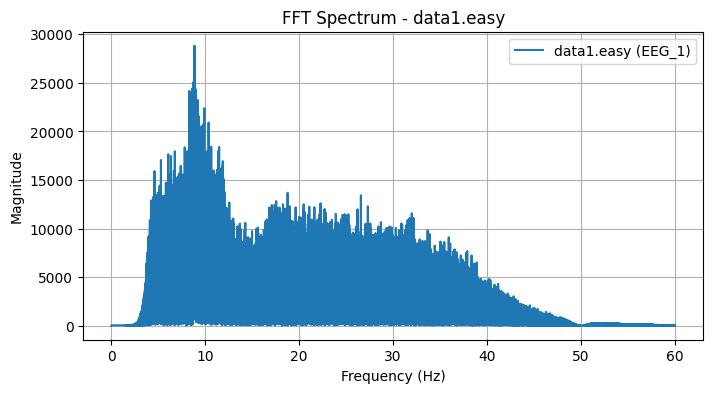

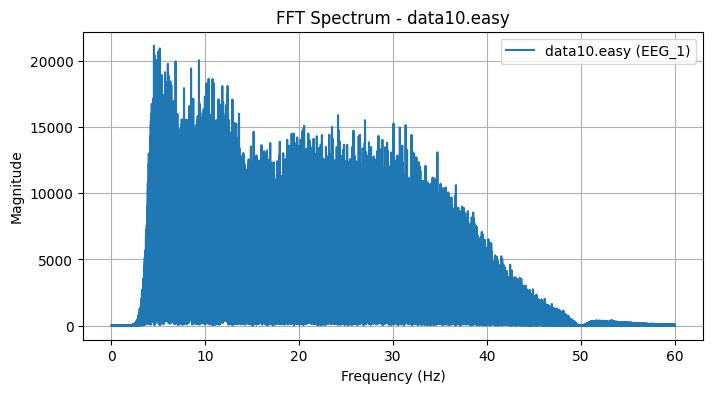

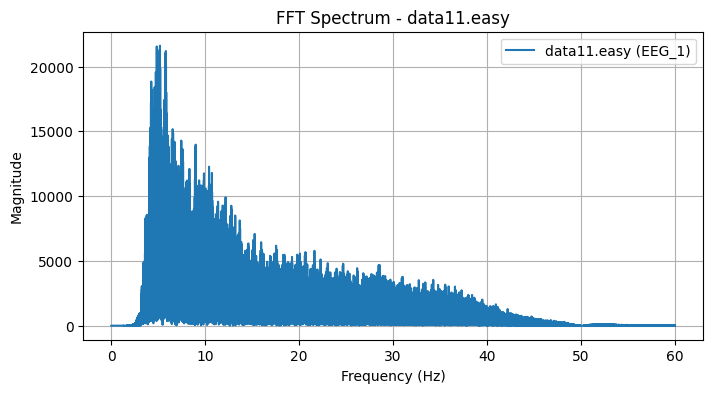

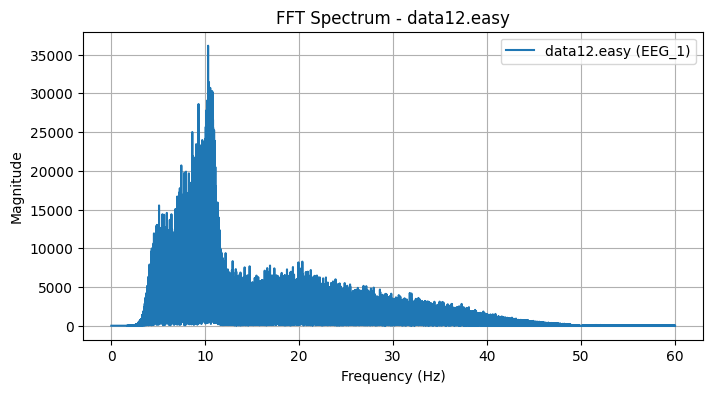

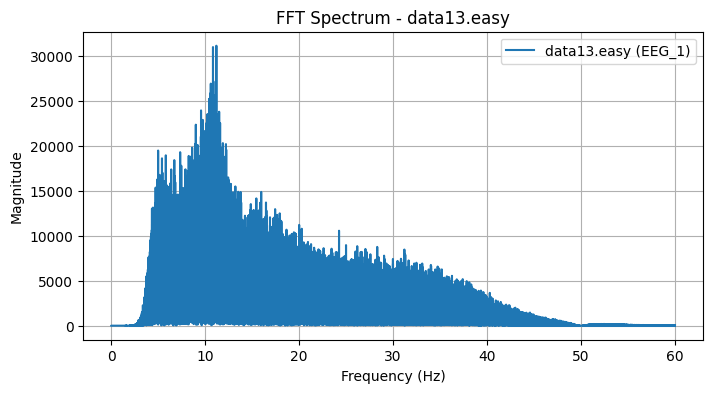

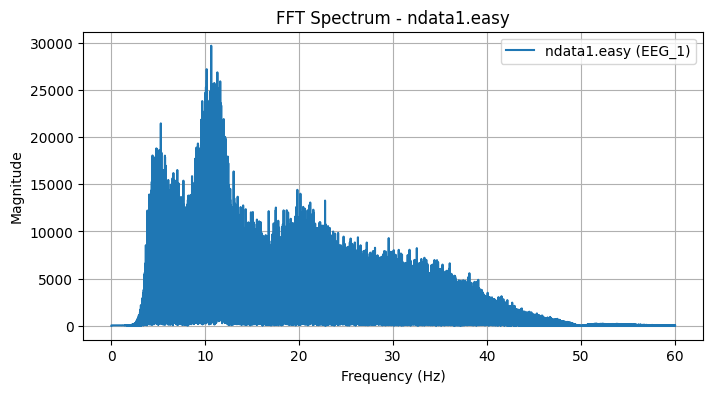

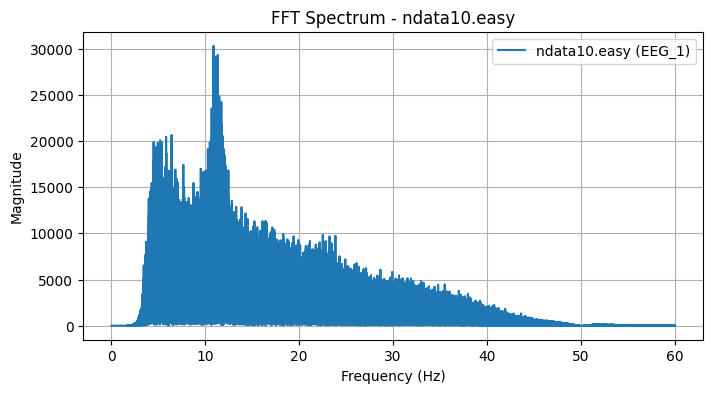

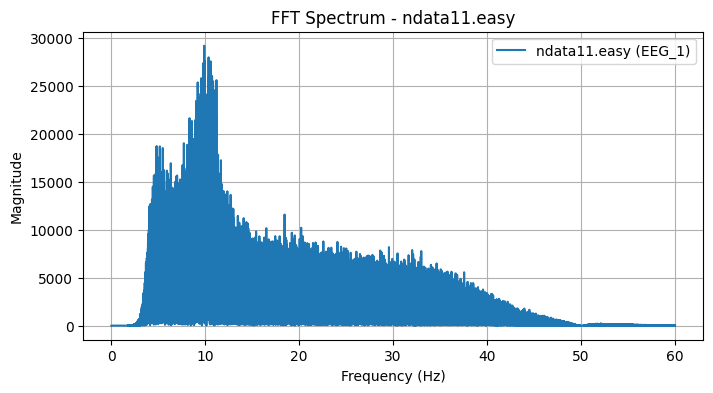

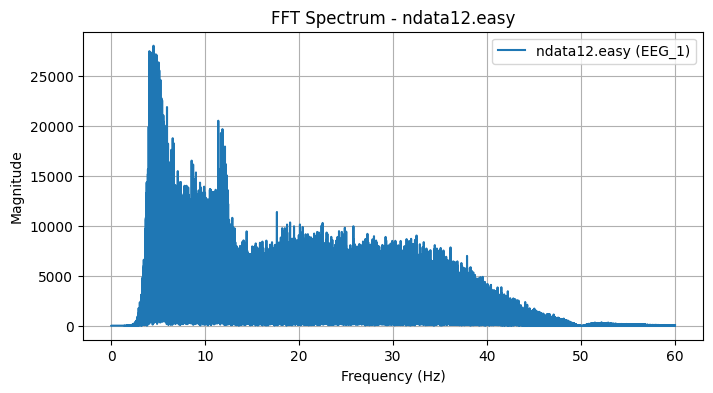

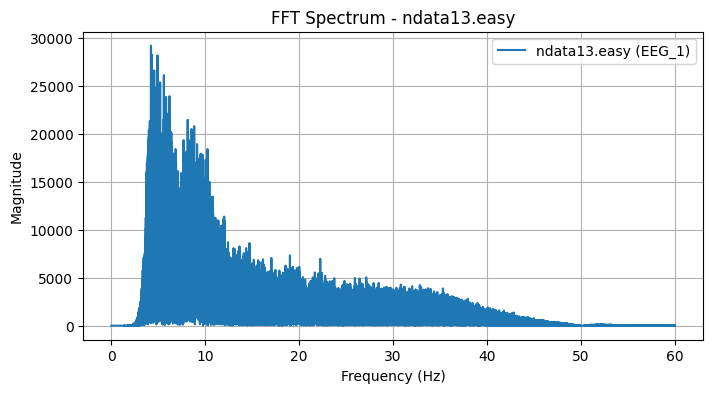

FFT computation and plotting complete.


In [ ]:
fft_results = {}
num_files = 17

for category in categories:
    category_path = os.path.join(data_path, category)
    category_files = sorted([f for f in os.listdir(category_path) if f.endswith(".easy")])[:num_files]

    for file in category_files:
        file_path = os.path.join(category_path, file)
        eeg_data, timestamps = process_eeg_file(file_path)

        if eeg_data is not None:
            freqs, fft_magnitudes = compute_fft(eeg_data)
            # Store FFT results
            fft_results[file] = {"frequencies": freqs, "magnitudes": fft_magnitudes}
            # Plot FFT for the first EEG channel
            plt.figure(figsize=(8, 4))
            plt.plot(freqs, fft_magnitudes[:, 0], label=f"{file} (EEG_1)")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude")
            plt.title(f"FFT Spectrum - {file}")
            plt.legend()
            plt.grid()
            plt.show()

print("FFT computation and plotting complete.")

For Cybersick data

In [ ]:
import matplotlib.pyplot as plt

# Define file paths
cybersick_file = "/content/drive/MyDrive/Cybersick/data1.easy"
normal_file = "/content/drive/MyDrive/Normal/ndata1.easy"

# Function to load EEG data (excluding accelerometer columns)
def load_eeg_data(file_path):
    df = pd.read_csv(file_path, delimiter="\t", header=None)

    # Retain only EEG columns and Timestamp
    df = df.iloc[:, list(range(8)) + [-1]]
    df.columns = [f"EEG_{i}" for i in range(1, 9)] + ["Timestamp"]

    return df

# Load data
df_cybersick = load_eeg_data(cybersick_file)
df_normal = load_eeg_data(normal_file)

# Display dataset info
print("Cybersick Data Info:")
print(df_cybersick.info())
print("\nNormal Data Info:")
print(df_normal.info())

# Show summary statistics
print("\nCybersick Data Summary:")
print(df_cybersick.describe())

print("\nNormal Data Summary:")
print(df_normal.describe())

Cybersick Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2909470 entries, 0 to 2909469
Data columns (total 9 columns):
 #   Column     Dtype
---  ------     -----
 0   EEG_1      int64
 1   EEG_2      int64
 2   EEG_3      int64
 3   EEG_4      int64
 4   EEG_5      int64
 5   EEG_6      int64
 6   EEG_7      int64
 7   EEG_8      int64
 8   Timestamp  int64
dtypes: int64(9)
memory usage: 199.8 MB
None

Normal Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889768 entries, 0 to 2889767
Data columns (total 9 columns):
 #   Column     Dtype
---  ------     -----
 0   EEG_1      int64
 1   EEG_2      int64
 2   EEG_3      int64
 3   EEG_4      int64
 4   EEG_5      int64
 5   EEG_6      int64
 6   EEG_7      int64
 7   EEG_8      int64
 8   Timestamp  int64
dtypes: int64(9)
memory usage: 198.4 MB
None

Cybersick Data Summary:
              EEG_1         EEG_2         EEG_3         EEG_4         EEG_5  \
count  2.909470e+06  2.909470e+06  2.909470e+06  2.909470e

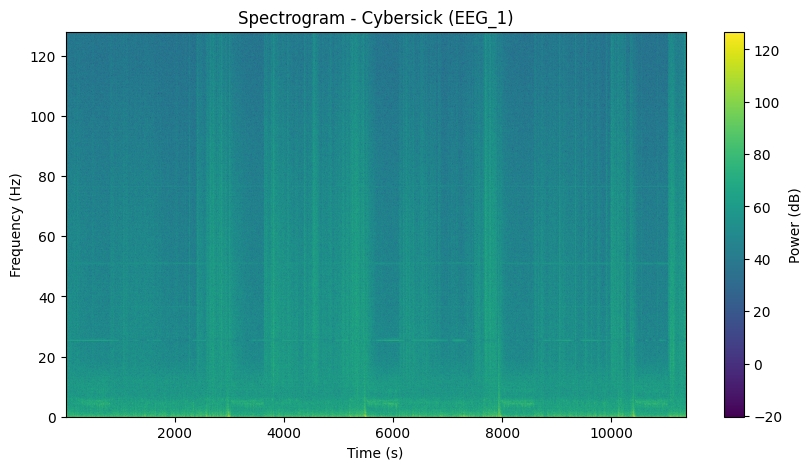

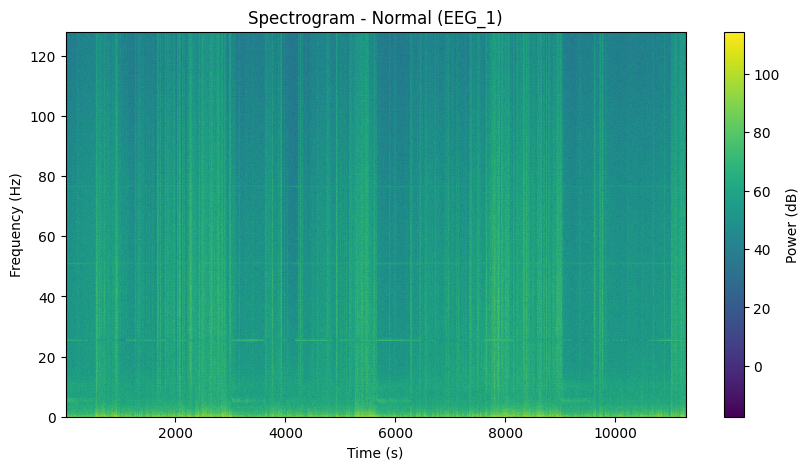

In [ ]:
import scipy.signal as signal

# Function to plot spectrogram for a given EEG channel
def plot_spectrogram(data, channel, title):
    fs = 256
    f, t, Sxx = signal.spectrogram(data[channel], fs, nperseg=1024)

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(f'Spectrogram - {title} ({channel})')
    plt.colorbar(label='Power (dB)')
    plt.show()

# Plot spectrogram for EEG_1 from both groups
plot_spectrogram(df_cybersick, "EEG_1", "Cybersick")
plot_spectrogram(df_normal, "EEG_1", "Normal")


In [ ]:
def plot_eeg_time_series(eeg_data, timestamps, file_name):
    """ Plot the time-series EEG signals for all 8 channels as subplots. """
    plt.figure(figsize=(12, 10))

    for ch in range(8):  # 8 EEG channels
        plt.subplot(8, 1, ch + 1)
        plt.plot(timestamps, eeg_data[:, ch], label=f"EEG_{ch+1}", color='b')
        plt.ylabel("Amplitude")
        plt.legend(loc="upper right")
        if ch == 0:
            plt.title(f"EEG Time Series - {file_name}")

    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

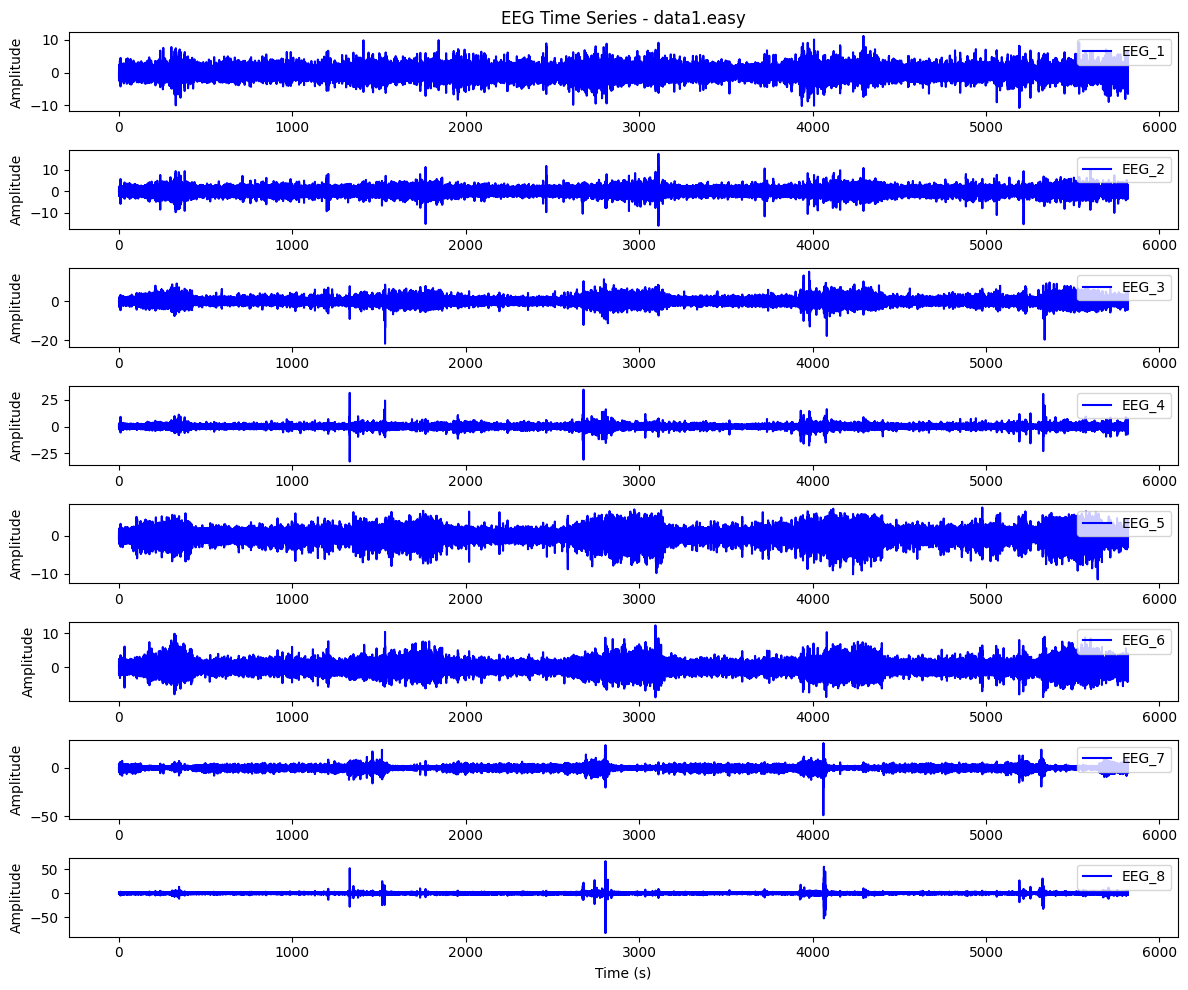

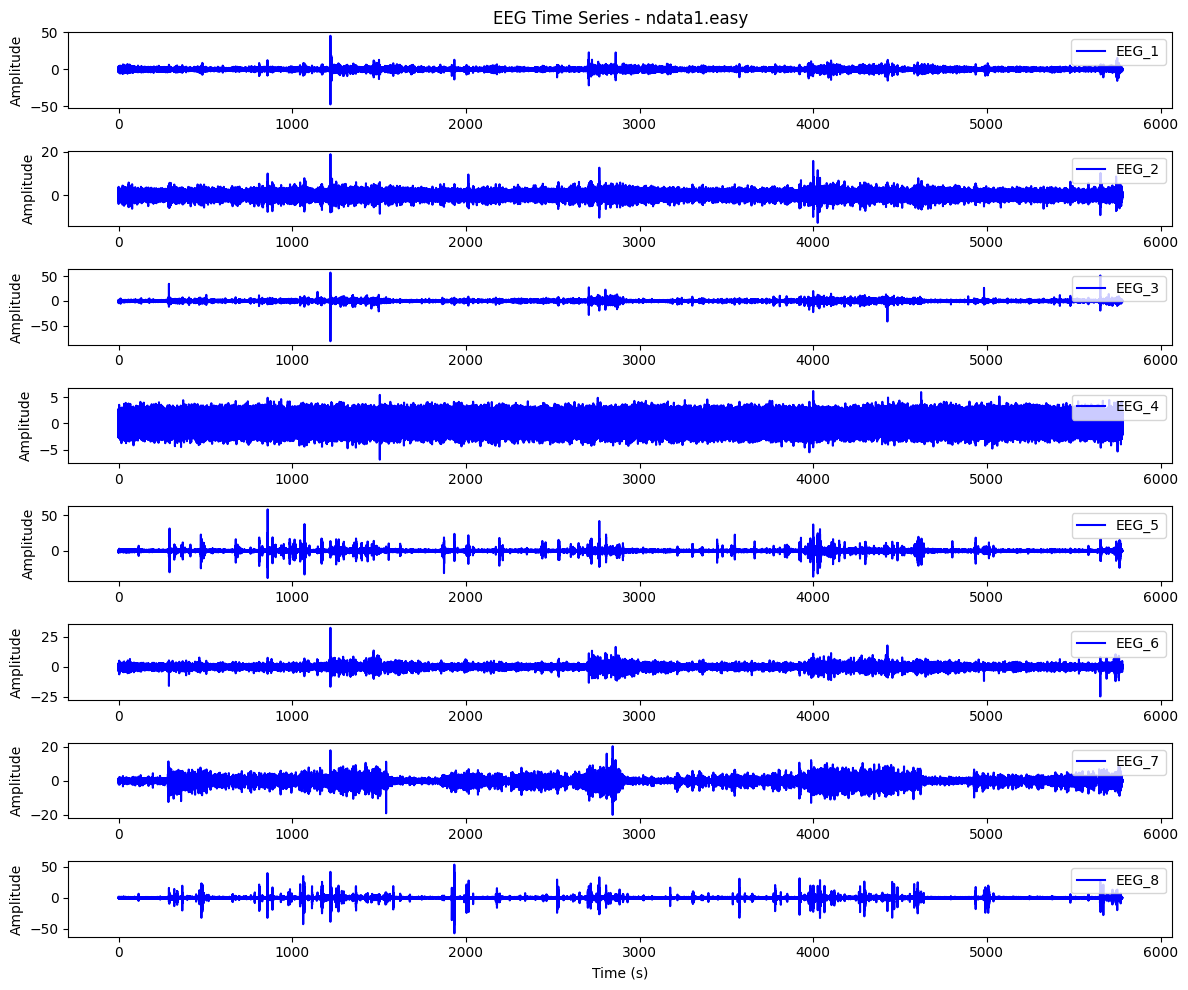

EEG time-series plotting complete.


In [ ]:
num_files = 1  # Plot only the first file per category to reduce clutter
data_path = "/content/drive/MyDrive/"  # Adjust path as needed
categories = ["Cybersick", "Normal"]

for category in categories:
    category_path = os.path.join(data_path, category)
    category_files = sorted([f for f in os.listdir(category_path) if f.endswith(".easy")])[:num_files]

    for file in category_files:
        file_path = os.path.join(category_path, file)
        df = pd.read_csv(file_path, delimiter='\t', header=None)

        timestamps = df.iloc[:, -1]

        eeg_data = process_eeg_file(file_path)

        if eeg_data is not None:
            # Convert timestamps to seconds
            timestamps = np.linspace(0, len(timestamps) / 500, num=len(timestamps))

            # Plot EEG time-series
            plot_eeg_time_series(eeg_data, timestamps, file)

print("EEG time-series plotting complete.")

In [ ]:
from scipy.signal import welch

def plot_psd(eeg_data, fs, file_name):
    plt.figure(figsize=(12, 8))

    for i in range(eeg_data.shape[1]):  # Loop through EEG channels
        f, psd = welch(eeg_data[:, i], fs=fs, nperseg=fs * 2)  # Welch’s method for PSD
        plt.semilogy(f, psd, label=f'EEG_{i+1}')

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (µV²/Hz)")
    plt.title(f"Power Spectral Density - {file_name}")
    plt.legend()
    plt.grid()
    plt.show()

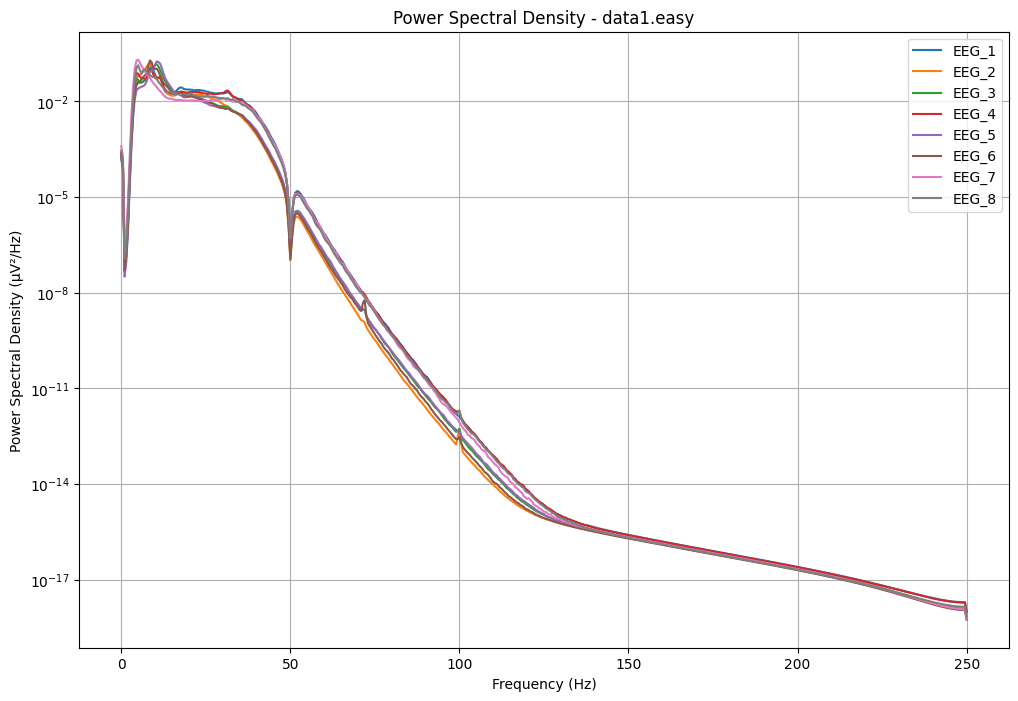

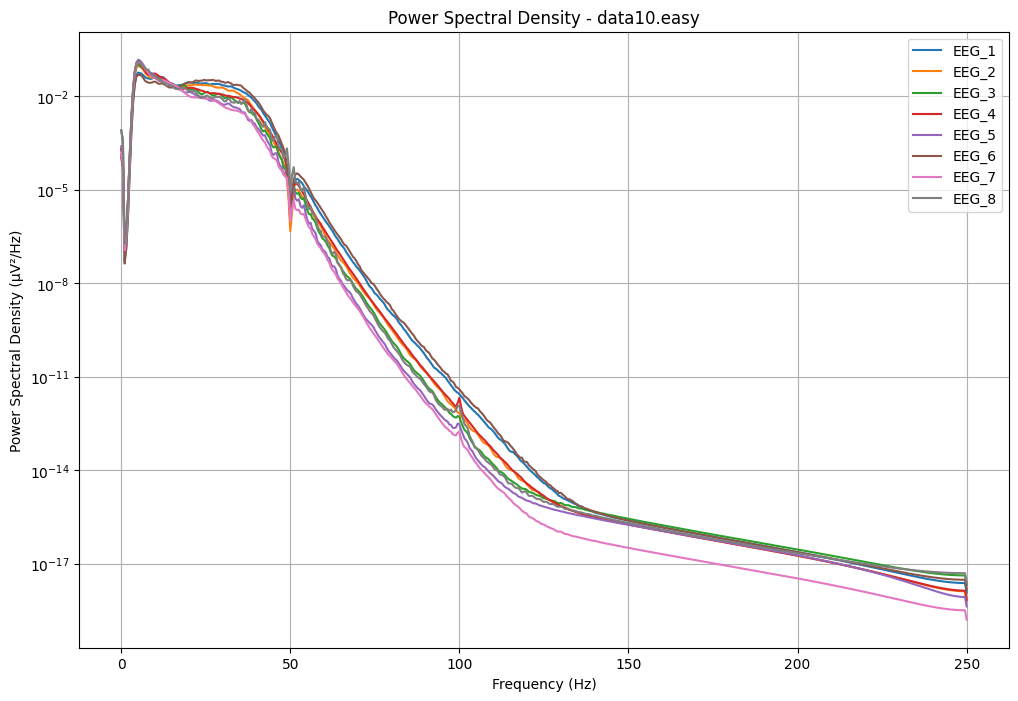

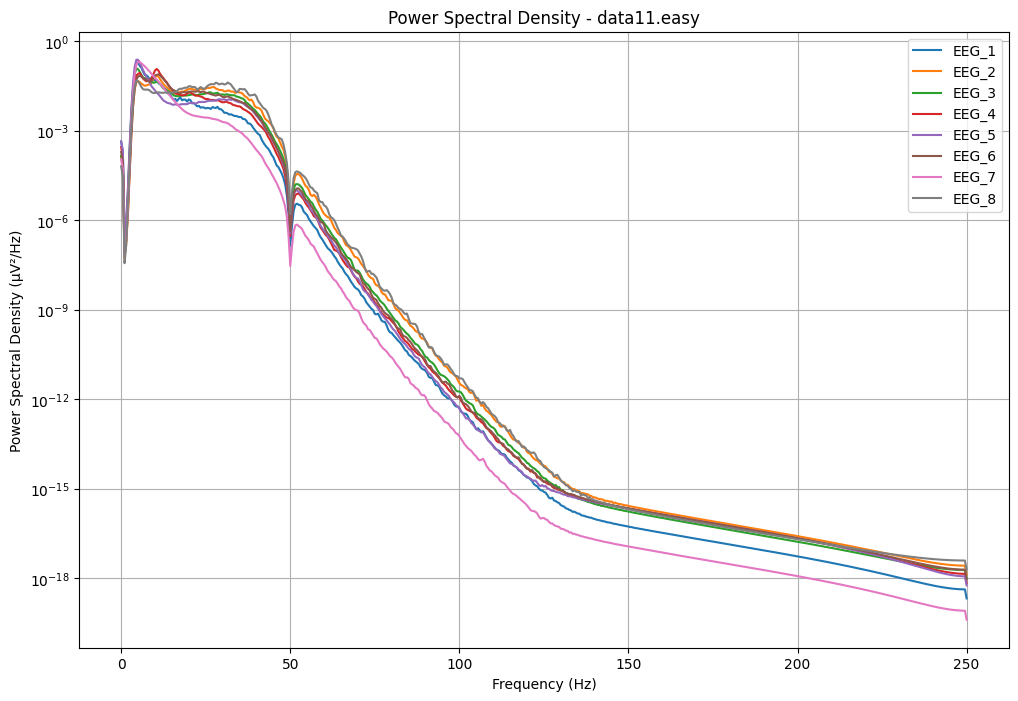

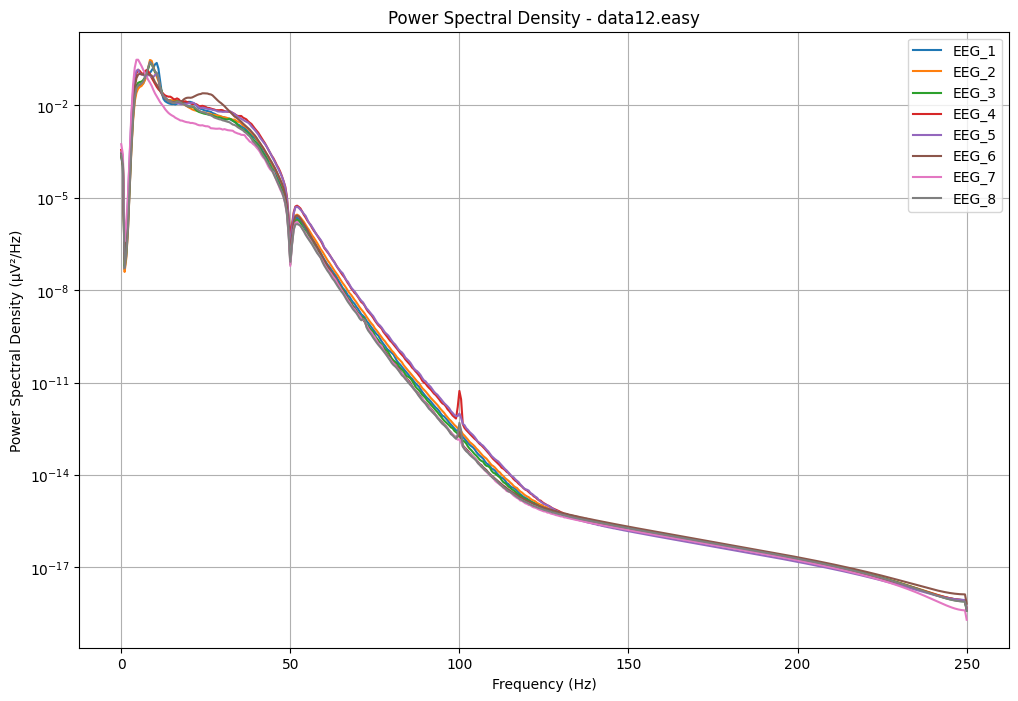

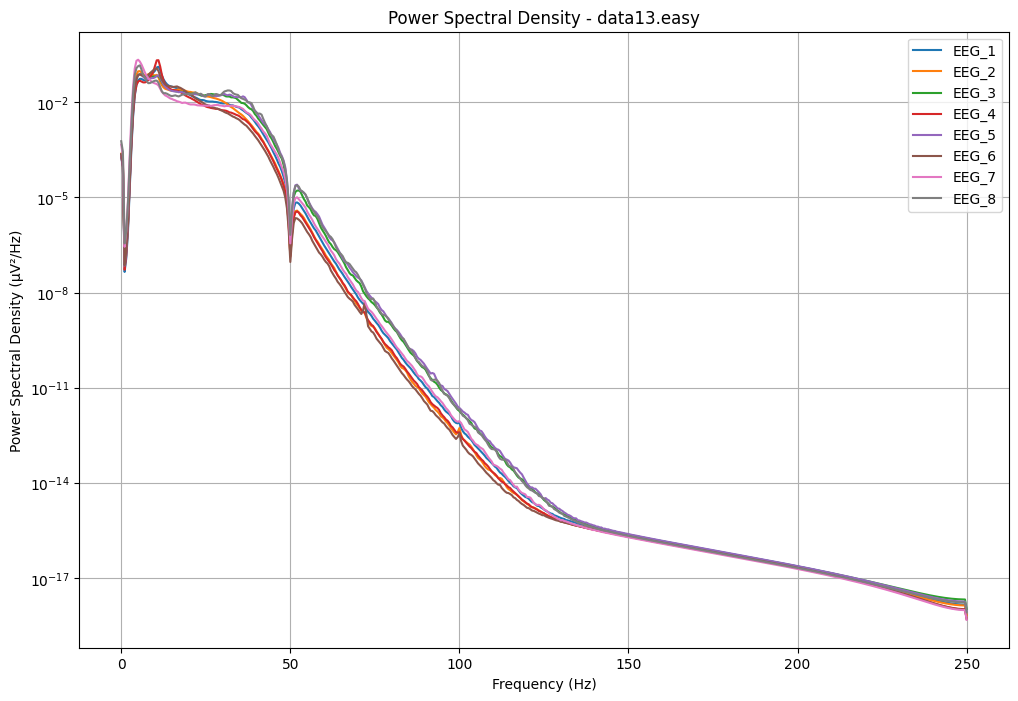

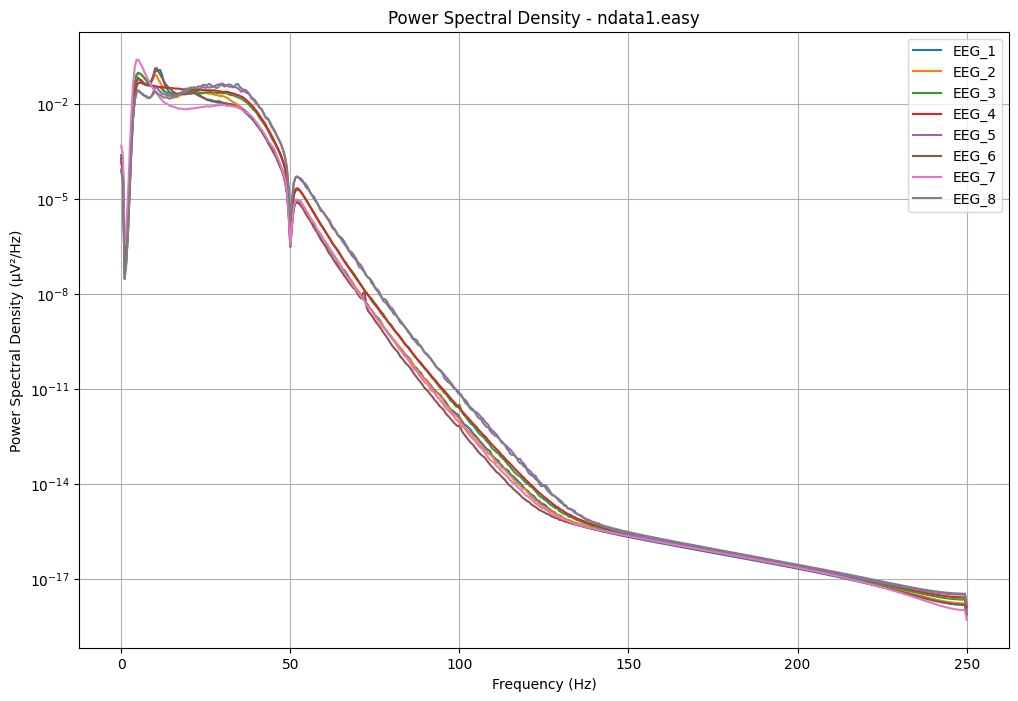

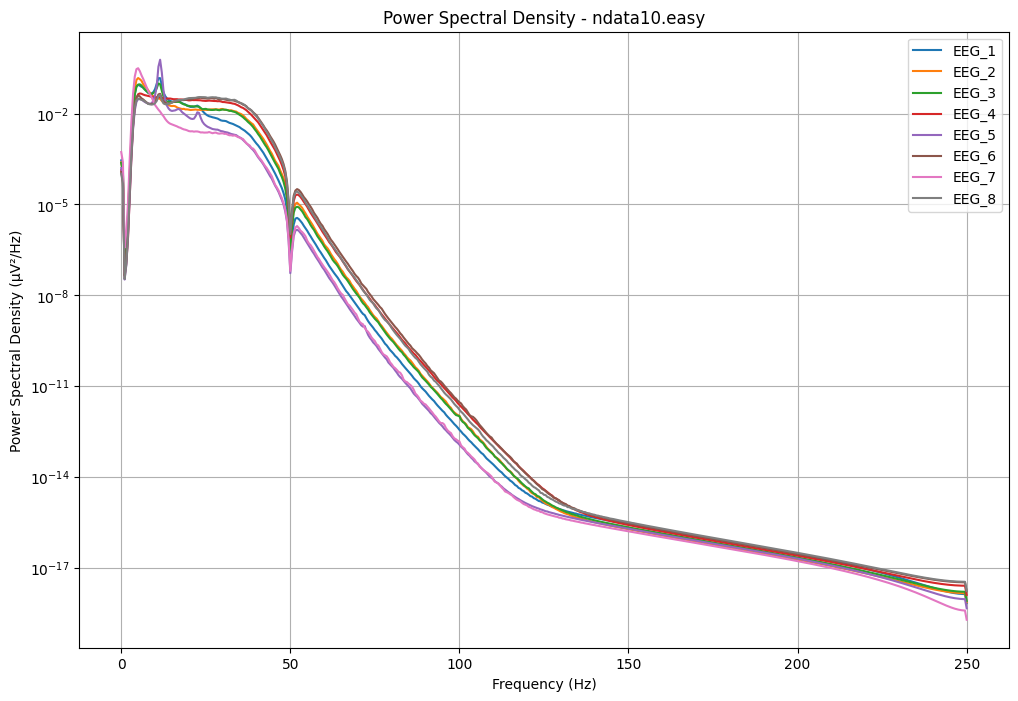

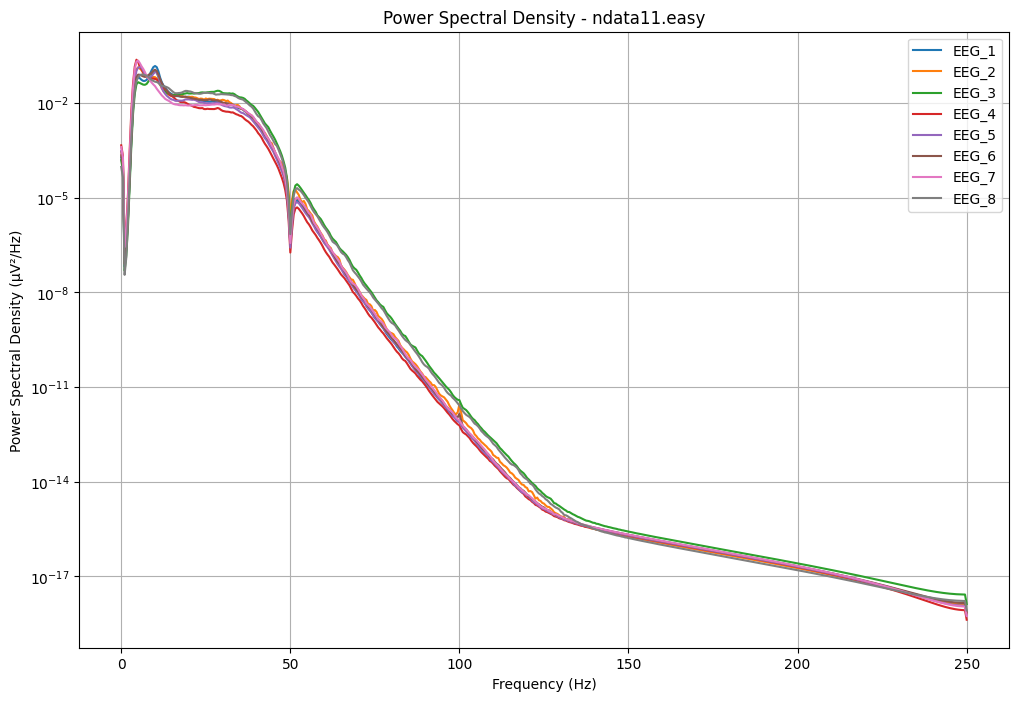

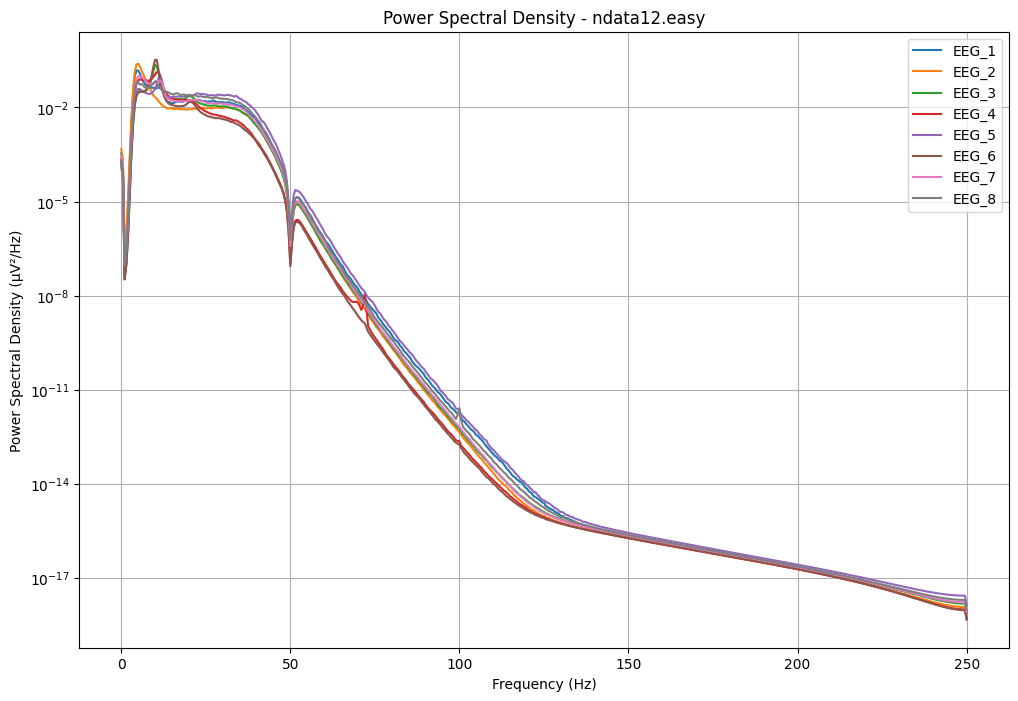

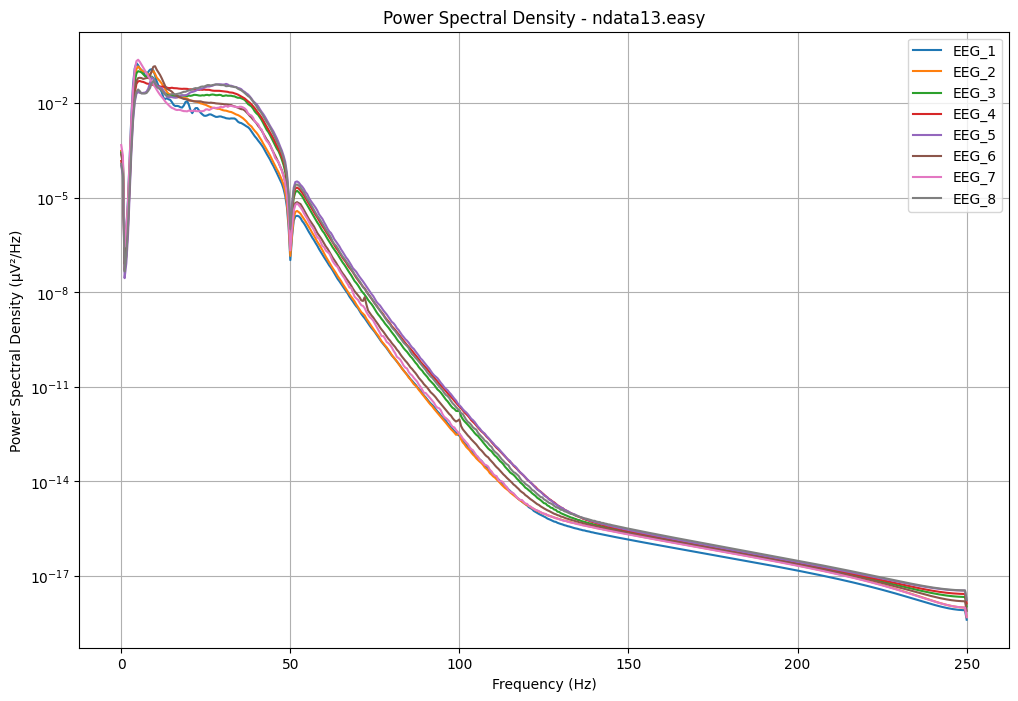

PSD computation and plotting complete.


In [ ]:
num_files = 5
fs = 500  # EEG Sampling frequency in Hz

for category in categories:
    category_path = os.path.join(data_path, category)
    category_files = sorted([f for f in os.listdir(category_path) if f.endswith(".easy")])[:num_files]

    for file in category_files:
        file_path = os.path.join(category_path, file)
        eeg_data, timestamps = process_eeg_file(file_path)

        if eeg_data is not None:
            plot_psd(eeg_data, fs, file)  # Plot PSD

print("PSD computation and plotting complete.")

In [ ]:
import numpy as np

def get_eeg_duration(file_path):
    try:
        data = np.loadtxt(file_path, delimiter='\t')  # Change delimiter if needed

        if data.shape[1] < 13:
            raise ValueError("File does not have enough columns. Expected at least 13.")

        timestamps = data[:, -1]

        # print(timestamps[-1], timestamps[0])


        duration = (timestamps[-1] - timestamps[0]) / 1000  # Convert from ms to seconds

        hours = int(duration // 3600)
        minutes = int((duration % 3600) // 60)

        print(f"Duration: {hours} hours {minutes} min")

    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

## **Model**

In [ ]:
def check_csv_dimensions(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Get the number of rows and columns
    num_rows, num_columns = df.shape

    return num_rows, num_columns

In [ ]:
# Cyber sick data dimensions
file_path = '/content/drive/MyDrive/cybersick_features.csv'  # Replace with your CSV file path
rows, columns = check_csv_dimensions(file_path)
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

Number of rows: 1629
Number of columns: 154


In [ ]:
# Normal Pre-processed data dimensions
file_path = '/content/drive/MyDrive/normal_features.csv'  # Replace with your CSV file path
rows, columns = check_csv_dimensions(file_path)
print(f"Number of rows: {rows}")
print(f"Number of columns: {columns}")

Number of rows: 1580
Number of columns: 154


After cleaning the data, certain pre-processing is still required to make it easily available to the model for the model to understand and work on it


In [ ]:
import pandas as pd

# Load both datasets
cybersick_df = pd.read_csv("/content/drive/MyDrive/cybersick_features.csv")
normal_df = pd.read_csv("/content/drive/MyDrive/normal_features.csv")

# Add class labels (1 for cybersick, 0 for normal)
cybersick_df["Label"] = 1
normal_df["Label"] = 0

# Combine datasets
df = pd.concat([cybersick_df, normal_df], axis=0).sample(frac=1).reset_index(drop=True)

# Separate features and labels
X = df.drop(columns=["Label", "File", "Segment"])  # Exclude non-numeric columns
y = df["Label"]

print("Shape of dataset:", X.shape)  # Should be (3209, 154)

Shape of dataset: (3209, 152)


Removing Low Variance features

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with variance below 0.01
selector = VarianceThreshold(threshold=0.01)
X_var_filtered = selector.fit_transform(X)

print("Reduced shape after variance threshold:", X_var_filtered.shape)

Reduced shape after variance threshold: (3209, 122)


Removing highly correlated features

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop(columns=["Label", "File", "Segment"])  # Drop non-feature columns
y = df["Label"]

### Step 1: Variance Thresholding ###
var_thresh = VarianceThreshold(threshold=0.01)  # Remove near-constant features
X = pd.DataFrame(var_thresh.fit_transform(X), columns=X.columns[var_thresh.get_support()])

### Step 2: Correlation Filtering ###
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X = X.drop(columns=to_drop)

### Step 3: Feature Selection using Random Forest ###
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance and select top 50 features
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
selected_features = feature_importances.nlargest(50).index
X_selected = X[selected_features]


In [ ]:
print("Shape after feature selection (Step 3):", X_selected.shape)

Shape after feature selection (Step 3): (3209, 50)


In [ ]:
### Step 4: PCA (Optional, If Features > 50) ###
if X_selected.shape[1] > 60:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)

    pca = PCA(n_components=20)  # Reduce to 20 components
    X_pca = pca.fit_transform(X_scaled)

    # Print explained variance
    print("Explained Variance Ratio:", pca.explained_variance_ratio_.cumsum())

    # Convert PCA output to DataFrame
    X_final = pd.DataFrame(X_pca, columns=[f"PCA_{i+1}" for i in range(X_pca.shape[1])])
else:
    X_final = X_selected

# Final dataset ready for training
print("Final shape:", X_final.shape)

Final shape: (3209, 50)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Load the processed feature dataset
X = X_final.values  # Feature matrix from feature selection
y = df["Label"].values  # Labels (1 for cybersickness, 0 for normal)

# Split the dataset into train, validation, and test sets (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape input for CNN and Transformer
input_shape = (X_train.shape[1], 1)  # Each feature treated as a channel
X_train = X_train.reshape(-1, input_shape[0], 1)
X_val = X_val.reshape(-1, input_shape[0], 1)
X_test = X_test.reshape(-1, input_shape[0], 1)

### CNN Branch ###
cnn_input = layers.Input(shape=input_shape)
x_cnn = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding="same")(cnn_input)
x_cnn = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="same")(x_cnn)
x_cnn = layers.MaxPooling1D(pool_size=2)(x_cnn)
x_cnn = layers.Flatten()(x_cnn)

### Transformer Branch ###
def transformer_block(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Dense(ff_dim, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

transformer_input = layers.Input(shape=input_shape)
x_trans = layers.Conv1D(filters=64, kernel_size=1, activation="relu")(transformer_input)
x_trans = transformer_block(x_trans)
x_trans = layers.GlobalAveragePooling1D()(x_trans)

### Fusion Layer ###
x = layers.Concatenate()([x_cnn, x_trans])
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(1, activation="sigmoid")(x)  # Binary classification

# Compile Model
model = models.Model(inputs=[cnn_input, transformer_input], outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# Model Summary
model.summary()

### **Training the Model** ###
history = model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val),
                    epochs=50, batch_size=32, verbose=1)

### **Evaluation on Test Set** ###
test_loss, test_acc = model.evaluate([X_test, X_test], y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26            │ (None, 50, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_41 (Conv1D)        │ (None, 50, 64)         │            128 │ input_layer_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_14   │ (None, 50, 64)         │         66,368 │ conv1d_41[0][0],       │
│ (MultiHeadAttention)      │                        │                │ conv1d_41[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_53 (Dropout)      │ (None, 50, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_28    │ (None, 50, 64)         │            128 │ dropout_53[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_25            │ (None, 50, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 50, 64)         │              0 │ layer_normalization_2… │
│                           │                        │                │ conv1d_41[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_39 (Conv1D)        │ (None, 50, 32)         │            128 │ input_layer_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 50, 128)        │          8,320 │ add_15[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_40 (Conv1D)        │ (None, 50, 64)         │          6,208 │ conv1d_39[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_54 (Dropout)      │ (None, 50, 128)        │              0 │ dense_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_14          │ (None, 25, 64)         │              0 │ conv1d_40[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_29    │ (None, 50, 128)        │            256 │ dropout_54[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten)      │ (None, 1600)           │              0 │ max_pooling1d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ layer_normalization_2… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13       

 Total params: 311,169 (1.19 MB)

 Trainable params: 311,169 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.5515 - loss: 0.8040 - val_accuracy: 0.6075 - val_loss: 0.6634
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6579 - loss: 0.6455 - val_accuracy: 0.6760 - val_loss: 0.5644
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7516 - loss: 0.5129 - val_accuracy: 0.7944 - val_loss: 0.4348
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8327 - loss: 0.4083 - val_accuracy: 0.8598 - val_loss: 0.3584
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8530 - loss: 0.3538 - val_accuracy: 0.8941 - val_loss: 0.2879
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8858 - loss: 0.2483 - val_accuracy: 0.8972 - val_loss: 0.2573
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9045 - loss: 0.2296 - val_accuracy: 0.9315 - val_loss: 0.2081
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9298 - loss: 0.1791 - val_accuracy: 0.9377 - val_los

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Get the true labels (y_test) and model predictions (y_pred)
y_true = y_test  # Make sure y_test is properly loaded
y_pred = model.predict([X_test, X_test])  # Pass X_test for both inputs
y_prob = model.predict([X_test, X_test])  # Pass X_test for both inputs


# Convert probabilities to class labels (0 or 1) using a threshold (e.g., 0.5)
y_pred_binary = (y_pred > 0.5).astype(int) #Converting y_pred to binary using threshold of 0.5


# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_binary))


# Compute AUC-ROC Score (for binary classification)
auc_roc = roc_auc_score(y_true, y_prob)  # y_prob is already probabilities
print(f"AUC-ROC Score: {auc_roc:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       159
           1       0.99      0.99      0.99       162

    accuracy                           0.99       321
   macro avg       0.99      0.99      0.99       321
weighted avg       0.99      0.99      0.99       321

AUC-ROC Score: 0.9991


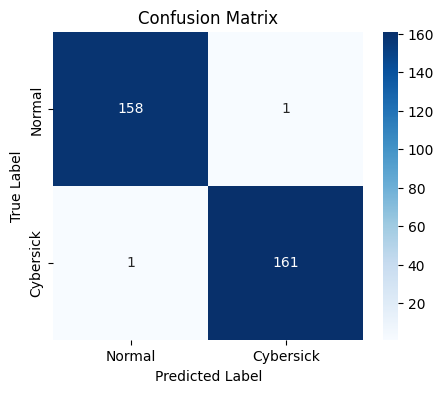

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Cybersick'], yticklabels=['Normal', 'Cybersick'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train a baseline model (Random Forest)
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Train a baseline model (RandomForest)
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Reshape X_train to 2D before fitting to RandomForestClassifier
X_train_2d = X_train.reshape(X_train.shape[0], -1)
baseline_model.fit(X_train_2d, y_train)
y_pred_baseline = baseline_model.predict(X_test.reshape(X_test.shape[0], -1)) # Reshape X_test as well


# Compute accuracy for both models
accuracy_cnn_transformer = accuracy_score(y_true, y_pred_binary)
accuracy_baseline = accuracy_score(y_true, y_pred_baseline)

# Print accuracies
print(f"CNN-Transformer Accuracy: {accuracy_cnn_transformer:.4f}")
print(f"Baseline Model Accuracy: {accuracy_baseline:.4f}")

# Perform t-test
# Convert y_pred_binary to 1D array
y_pred_binary_1d = y_pred_binary.ravel()

# Ensure y_pred_baseline and y_pred_binary_1d are of the same data type
y_pred_binary_1d = y_pred_binary_1d.astype(y_pred_baseline.dtype)

t_stat, p_value = ttest_ind(y_pred_binary_1d, y_pred_baseline, equal_var=False, nan_policy='omit')

# Interpret results
alpha = 0.05  # Significance level
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

if p_value < alpha:
    print("The CNN-Transformer model significantly outperforms the baseline (statistically significant).")
else:
    print("No significant difference between the models (p-value > 0.05).")

CNN-Transformer Accuracy: 0.9938
Baseline Model Accuracy: 0.9907
T-Statistic: 0.0788, P-Value: 0.9372
No significant difference between the models (p-value > 0.05).


In [ ]:
# Save in the new Keras format (recommended)
model.save("cnn_transformer_eeg_model.keras")

# OR save in HDF5 format (still works, just considered legacy)
model.save("cnn_transformer_eeg_model.h5")

In [ ]:
def live_predict(file_path, model_path):
    # Load trained model
    model = load_model(model_path)

    # Process raw EEG file
    eeg_data, timestamps = process_eeg_file(file_path)
    if eeg_data is None:
        print("EEG data could not be processed.")
        return

    # Segment (usually only 1 segment for live demo)
    segments = segment_eeg(eeg_data, timestamps, segment_duration=60, fs=500)
    if not segments:
        print("EEG file too short for 60s segment.")
        return

    for i, segment in enumerate(segments):
        # Extract features
        features = compute_features(segment)
        feature_df = pd.DataFrame([features])

        # Apply the same feature selection as training
        top_50_features = ['Ch1_Mean', 'Ch1_Std', 'Ch1_Variance', 'Ch1_Skewness', 'Ch1_Kurtosis', 'Ch1_RMS', 'Ch1_Peak-to-Peak', 'Ch1_Entropy', 'Ch1_Delta_Power', 'Ch1_Delta_Relative_Power', 'Ch1_Theta_Power', 'Ch1_Theta_Relative_Power', 'Ch1_Alpha_Power', 'Ch1_Alpha_Relative_Power', 'Ch1_Beta_Power', 'Ch1_Beta_Relative_Power', 'Ch1_Gamma_Power', 'Ch1_Gamma_Relative_Power', 'Ch1_Peak_Frequency', 'Ch2_Mean', 'Ch2_Std', 'Ch2_Variance', 'Ch2_Skewness', 'Ch2_Kurtosis', 'Ch2_RMS', 'Ch2_Peak-to-Peak', 'Ch2_Entropy', 'Ch2_Delta_Power', 'Ch2_Delta_Relative_Power', 'Ch2_Theta_Power', 'Ch2_Theta_Relative_Power', 'Ch2_Alpha_Power', 'Ch2_Alpha_Relative_Power', 'Ch2_Beta_Power', 'Ch2_Beta_Relative_Power', 'Ch2_Gamma_Power', 'Ch2_Gamma_Relative_Power', 'Ch2_Peak_Frequency', 'Ch3_Mean', 'Ch3_Std', 'Ch3_Variance', 'Ch3_Skewness', 'Ch3_Kurtosis', 'Ch3_RMS', 'Ch3_Peak-to-Peak', 'Ch3_Entropy', 'Ch3_Delta_Power', 'Ch3_Delta_Relative_Power', 'Ch3_Theta_Power', 'Ch3_Theta_Relative_Power', 'Ch3_Alpha_Power']
        missing_cols = set(top_50_features) - set(feature_df.columns)
        for col in missing_cols:
            feature_df[col] = 0
        feature_df = feature_df[top_50_features]  # Reorder columns

        # Reshape for model
        X_input = feature_df.values.reshape(-1, len(top_50_features), 1)

        print("Model input shape:", model.input_shape)
        print("X_input shape:", X_input.shape)


        # Prediction
        prediction = model.predict(X_input)
        label = "Cybersick" if prediction[0][0] > 0.5 else "Normal"
        print(f"Segment {i+1}: {label} (Probability: {prediction[0][0]:.4f})")

In [ ]:
def save_trained_model(model, save_path="cybersickness_model.h5"):
    model.save(save_path)
    print(f"Model saved to {save_path}")
